In [19]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

data_dir = "/home/23ucs747/mini-project-sem5/dataset_split/test"
model_base_path = "/home/23ucs747/mini-project-sem5/models/efficientnet_b0_base.pth"
model_retrained_path = "/home/23ucs747/mini-project-sem5/models/efficientnet_b0_retrained.pth"

Using device: cuda


In [21]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(root=data_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)
class_names = test_dataset.classes
print(f"Loaded test dataset: {len(test_dataset)} images across {len(class_names)} classes.")

Loaded test dataset: 840 images across 4 classes.


In [22]:
def load_model(weight_path):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 4)
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [23]:
def evaluate_model(model, loader, name="Model"):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f"Evaluating {name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
    print(f"{name} Accuracy: {acc:.2f}%")
    return np.array(all_preds), np.array(all_labels), acc


In [24]:
base_model = load_model(model_base_path)
retrained_model = load_model(model_retrained_path)

pred_base, labels_base, acc_base = evaluate_model(base_model, test_loader, name="Base Model")
pred_retrained, labels_retrained, acc_retrained = evaluate_model(retrained_model, test_loader, name="Retrained Model")

Evaluating Base Model: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 28.42it/s]


Base Model Accuracy: 94.76%


Evaluating Retrained Model: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 29.55it/s]

Retrained Model Accuracy: 94.52%


In [25]:
print("\nBase Model Report:")
print(classification_report(labels_base, pred_base, target_names=class_names))

print("\nRetrained Model Report:")
print(classification_report(labels_retrained, pred_retrained, target_names=class_names))


Base Model Report:
                precision    recall  f1-score   support

        Blight       0.91      0.91      0.91       230
   Common_Rust       0.97      0.98      0.98       262
Gray_Leaf_Spot       0.86      0.83      0.84       115
       Healthy       1.00      1.00      1.00       233

      accuracy                           0.95       840
     macro avg       0.94      0.93      0.93       840
  weighted avg       0.95      0.95      0.95       840


Retrained Model Report:
                precision    recall  f1-score   support

        Blight       0.90      0.91      0.91       230
   Common_Rust       0.97      0.98      0.98       262
Gray_Leaf_Spot       0.86      0.83      0.84       115
       Healthy       1.00      1.00      1.00       233

      accuracy                           0.95       840
     macro avg       0.93      0.93      0.93       840
  weighted avg       0.94      0.95      0.94       840



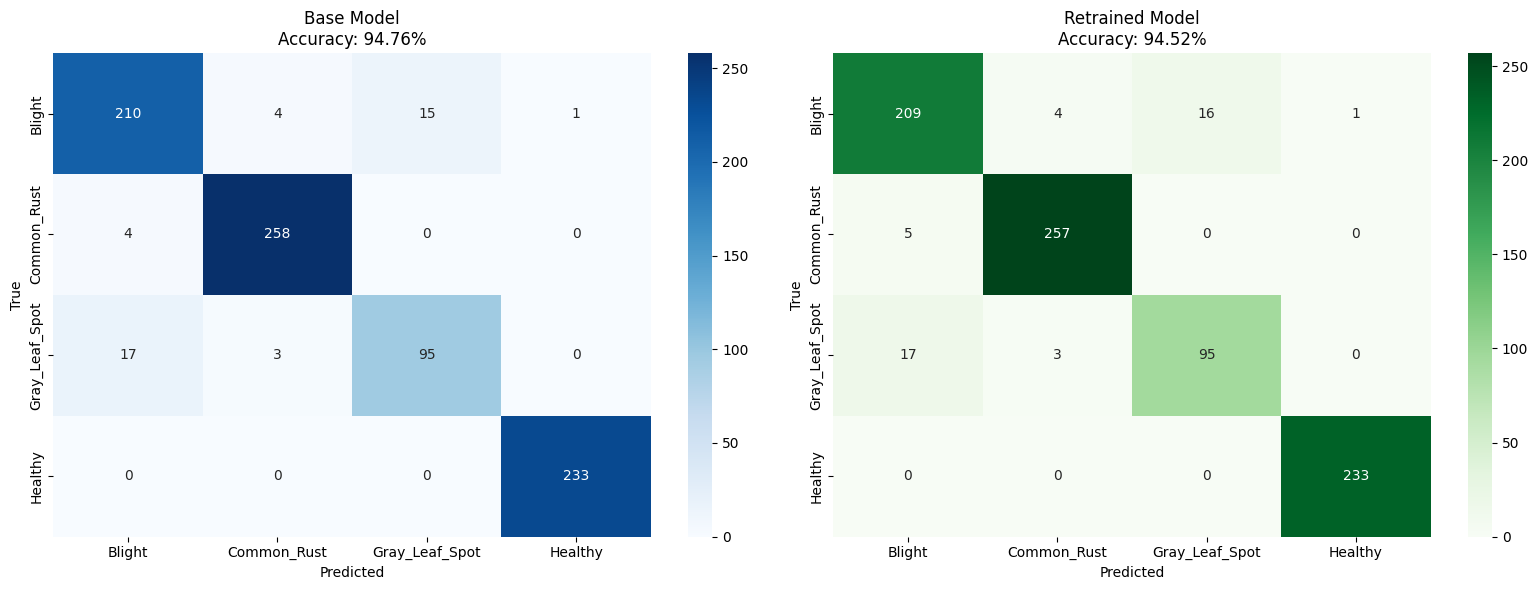

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(confusion_matrix(labels_base, pred_base), annot=True, fmt="d",
            xticklabels=class_names, yticklabels=class_names, cmap="Blues", ax=axes[0])
axes[0].set_title(f"Base Model\nAccuracy: {acc_base:.2f}%")

sns.heatmap(confusion_matrix(labels_retrained, pred_retrained), annot=True, fmt="d",
            xticklabels=class_names, yticklabels=class_names, cmap="Greens", ax=axes[1])
axes[1].set_title(f"Retrained Model\nAccuracy: {acc_retrained:.2f}%")

for ax in axes:
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()

In [27]:
results_df = pd.DataFrame({
    "Model": ["Base", "Retrained"],
    "Accuracy": [acc_base, acc_retrained]
})
results_path = "/home/23ucs747/mini-project-sem5/model_comparison_results.csv"
results_df.to_csv(results_path, index=False)
print(f"Results saved to: {results_path}")

Results saved to: /home/23ucs747/mini-project-sem5/model_comparison_results.csv
